## Import Libraries

In [1]:
%matplotlib inline

import os
import copy
import time
import torch
import shutil
import random
import torchvision
import numpy as np
import pandas as pd

from PIL import Image
from matplotlib import pyplot as plt

torch.manual_seed(0)
TRAIN = 'train'
TEST = 'test'

print('Using PyTorch version', torch.__version__)

Using PyTorch version 1.10.2


## Preparing Training and Test Sets

In [2]:
VAL_SIZE = 0.2

class_names = ['normal', 'viral', 'covid']
root_dir = 'COVID-19_Radiography_Dataset'
source_dirs = ['Normal/images', 'Viral Pneumonia/images', 'COVID/images']

if os.path.isdir(os.path.join(root_dir, source_dirs[1])):
    os.mkdir(os.path.join(root_dir, 'train'))
    os.mkdir(os.path.join(root_dir, 'test'))

    for c in class_names:
        os.mkdir(os.path.join(root_dir, 'train', c))
        os.mkdir(os.path.join(root_dir, 'test', c))

    for i, d, in enumerate(source_dirs):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, 'train', class_names[i]))

    for c in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, 'train', c)) if x.lower().endswith('png')]
        selected_images = random.sample(images, int(len(images) * VAL_SIZE))
        for image in selected_images:
            source_path = os.path.join(root_dir, 'train', c, image)
            target_path = os.path.join(root_dir, 'test', c, image)
            shutil.move(source_path, target_path)

## Creating Custom Dataset

In [53]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name, verbose=1):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            if verbose == 1:
                print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']

        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
        
        self.df = {'image': [], 'label': []}
        for label, images in self.images.items():
            for image in images:
                self.df['image'].append(image)
                self.df['label'].append(label)

        self.df = pd.DataFrame(self.df, columns=self.df.keys())
        self.df = self.df.sample(frac=1, random_state=42).reset_index(drop=True)
        
        self.df.to_csv('data.csv')
        
        self.image_dirs = image_dirs
        self.transform = transform

    def __len__(self):
        return len(self.df)
        # return sum([len(self.images[class_name]) for class_name in self.class_names])

    def __getitem__(self, index):
        # class_name = random.choice(self.class_names)
        # index = index % len(self.images[class_name])
        # image_name = self.images[class_name][index]
        
        if torch.is_tensor(index):
            index = index.tolist()
        
        image_name = self.df.iloc[index][0]
        class_name = self.df.iloc[index][1]
        
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)


## Image transformation

In [54]:
train_transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [55]:
test_transform = torchvision.transforms.Compose(transforms=[
    torchvision.transforms.Grayscale(num_output_channels=3),
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
])

In [56]:
data_transforms = {
    TRAIN: train_transform,
    TEST: test_transform,
}

## Data Loader

In [57]:
train_dirs = {}
for class_name in class_names:
    train_dirs[class_name] = os.path.join(root_dir, 'train', class_name)

train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 8154 normal examples
Found 1076 viral examples
Found 2893 covid examples
X length: 12123
y length: 12123


In [58]:
test_dirs = {}
for class_name in class_names:
    test_dirs[class_name] = os.path.join(root_dir, 'test', class_name)

test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 2038 normal examples
Found 269 viral examples
Found 723 covid examples
X length: 3030
y length: 3030


In [51]:
image_datasets = {
    TRAIN: train_dataset,
    TEST: test_dataset,
}

In [10]:
batch_size = 8

dataloader_train = torch.utils.data.DataLoader(train_dataset, 
                                        batch_size=batch_size,
                                        shuffle=True)

dataloader_test = torch.utils.data.DataLoader(test_dataset,
                                        batch_size=batch_size,
                                        shuffle=True)

dataloaders = {
    TRAIN: dataloader_train,
    TEST: dataloader_test,
}

print('Num. of training batches', len(dataloader_train))
print('Num. of test batches', len(dataloader_test))

Num. of training batches 1516
Num. of test batches 379


## Data Visualization

In [11]:
class_names = image_datasets[TRAIN].class_names

def show_images(images, labels, preds):
    plt.figure(figsize=(12, 8))
    for i, image in enumerate(images):
        plt.subplot(1, 8, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)

        col = 'lime' if preds[i] == labels[i] else 'red'

        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

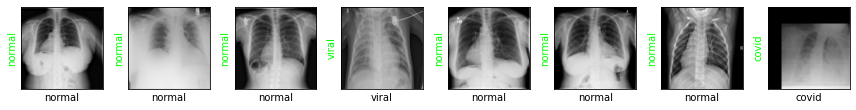

In [12]:
itr_train = iter(dataloaders[TRAIN])
images, labels = next(itr_train)
show_images(images, labels, labels)

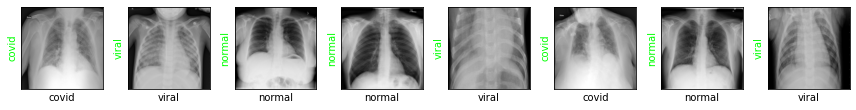

In [13]:
itr_test = iter(dataloaders[TEST])
images, labels = next(itr_test)
show_images(images, labels, labels)

## Create the Model

In [14]:
resnet18 = torchvision.models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# from torchsummary import summary

# first_parameter = next(resnet18.parameters())
# input_shape = first_parameter.size()
# print(input_shape)

# summary(resnet18, input_shape)

In [16]:
resnet18.fc = torch.nn.Linear(in_features=512,
                              out_features=3)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=resnet18.parameters(),
                             lr=1e-4)

In [17]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dataloader_test))
    outputs = resnet18(images)
    _, preds = torch.max(input=outputs, dim=1) # return probalility of the max class and indices of the class
    # preds = torch.argmax(input=Tensor)
    show_images(images, labels, preds)

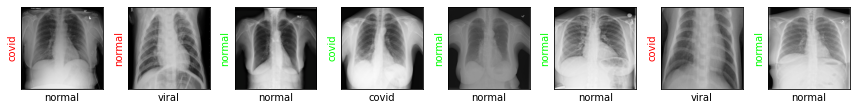

In [18]:
show_preds()

## Training the Model

In [61]:
def train_model(model, criterion, optimizer, scheduler=None, device='cpu', epochs=25):
    print("Starting training..")
    since = time.time()
    
    best_model_weights = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in range(0, epochs):
        print(f'Epoch {epoch + 1}/{epochs}')
        print('-' * 10)
        
        # Each epoch has a training and validation phase
        for phase in [TRAIN, TEST]:
            if phase == TRAIN:
                model.train()
            else:
                model.eval()
                
            running_loss = 0.0
            running_corrects = 0

            for step, (inputs, labels) in enumerate(dataloaders[phase]):
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # zero the parameter gradients
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(input=outputs, dim=1)
                    loss = criterion(outputs, labels)

                    # backpropagation
                    if phase == TRAIN:
                        loss.backward()        
                        optimizer.step()
                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += sum((labels == preds).numpy())

            if scheduler is not None and phase == TRAIN:
                scheduler.step()
            
            epoch_loss = running_loss / len(dataloaders[phase])
            epoch_acc = running_corrects / len(dataloaders[phase])
            
            # Print history after each epoch
            print(f'{phase} loss: {epoch_loss:.4f}, acc: {epoch_acc:.4f}')
            
            # Save best model
            if phase == TEST and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_weights = copy.deepcopy(model.state_dict())
                
        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best validation accuracy: {best_acc}')
    
    # load best model and return 
    model.load_state_dict(best_model_weights)
    return model

In [ ]:
train_model(model=resnet18,
            criterion=loss_fn,
            optimizer=optimizer,
            epochs=1)

In [31]:
PATH = 'entire_model.pt'

torch.save(resnet18, PATH)


## Final Result

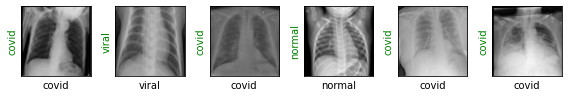

In [35]:
resnet18 = torch.load(PATH)
show_preds()

In [ ]:
show_preds()

Text(0.5, 69.0, 'Predicted label')

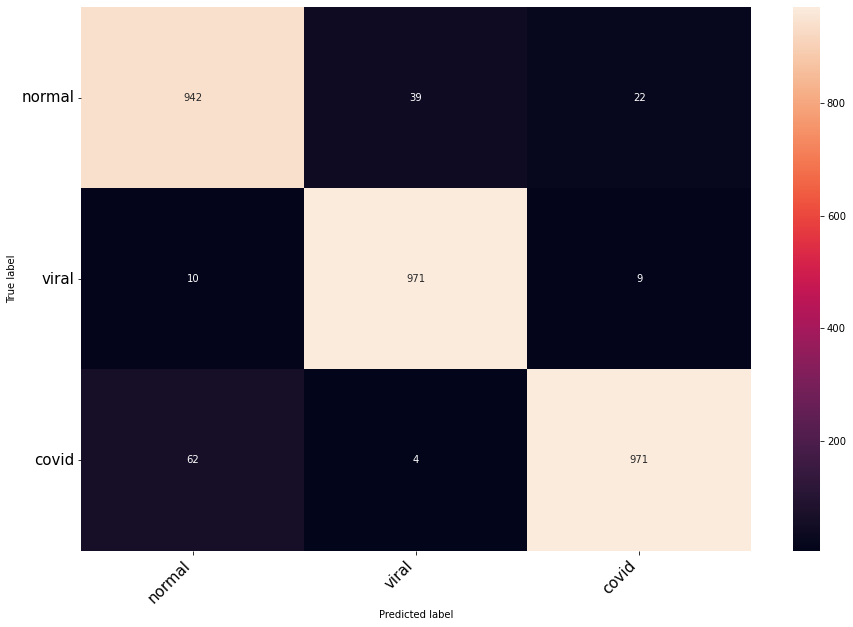

In [29]:
import pandas as pd
import seaborn as sns

DEVICE = 'cpu'
nb_classes = 3

confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloader_test):
        inputs = inputs.to(DEVICE)
        classes = classes.to(DEVICE)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(classes.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

plt.figure(figsize=(15,10))

df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
heatmap = sns.heatmap(df_cm, annot=True, fmt="d")

heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=15)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=15)
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [27]:
from sklearn.metrics import confusion_matrix

nb_classes = 3
device = 'cpu'

# Initialize the prediction and label lists(tensors)
predlist=torch.zeros(0,dtype=torch.long, device='cpu')
lbllist=torch.zeros(0,dtype=torch.long, device='cpu')

with torch.no_grad():
    for i, (inputs, classes) in enumerate(dataloader_test):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = resnet18(inputs)
        _, preds = torch.max(outputs, 1)

        # Append batch prediction results
        predlist=torch.cat([predlist,preds.view(-1).cpu()])
        lbllist=torch.cat([lbllist,classes.view(-1).cpu()])

# Confusion matrix
conf_mat=confusion_matrix(lbllist.numpy(), predlist.numpy())
print(conf_mat)

# Per-class accuracy
class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
print(class_accuracy)

[[ 949   26   24]
 [   8 1020    7]
 [  62    6  928]]
[94.99499499 98.55072464 93.17269076]
